In [1]:
import sys
import os

# Add the path to your ML directory
sys.path.append(r'C:\Users\admin\Documents\Masters\ES_Masters\Masters-Processing\ML')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from mrmr_wrapper import MRMRTransformer
from sklearn.svm import SVC
import optuna
import optuna.visualization as vis
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay

# Import Data

In [2]:
# Load the data
file_path = "features-Master.csv"
data = pd.read_csv(file_path)

# Shuffle the data
shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)
data_shuffled = shuffled.iloc[:, 4:]
labels_shuffled = shuffled["Comfort Score"]

# Create binary labels (1,2 = 0; 4,5 = 1; exclude 3 for clearer separation)
binary_labels = labels_shuffled.apply(lambda x: 0 if x <= 2 else (1 if x >=4 else np.nan))
binary_data = data_shuffled[~binary_labels.isna()]
binary_labels = binary_labels[~binary_labels.isna()] 

# Train/Test Split

In [3]:
# For binary classification
X_train, X_test, y_train, y_test = train_test_split(
    binary_data,
    binary_labels,
    test_size=0.2,
    stratify=binary_labels,
    random_state=42
)

# Handle missing values

In [4]:
imputer = SimpleImputer(strategy='median')

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Scale Data
- Recommended for SVM models
- sklearn StandardScaler() may not work well with outliers (should check for outliers)

In [5]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

# Optimize Feature Selection and SVM Parameters

In [6]:
X = X_train_scaled.copy()
y = y_train.copy()

def binary_classification_objective(trial):
    # Feature selection, only optimizing method and number of features (no hyperparameters of the methods)
    fs_method = trial.suggest_categorical('feature_selection', ['MRMR', 'RFE', 'None'])
    
    if fs_method != 'None':
        k_features = trial.suggest_int('k_features', 5, 105, step = 10) # Only allow a maximum of 105 features to be selected, with a step of 10, to go up to all features: X.shape[1]
        if fs_method == 'RFE':
            estimator = RandomForestClassifier()
            selector = RFE(estimator, n_features_to_select=k_features)
        else: #MRMR
            selector = MRMRTransformer(k_features=k_features) #https://feature-engine.trainindata.com/en/1.8.x/api_doc/selection/MRMR.html#feature_engine.selection.MRMR
    else:
        selector = 'passthrough'
    
    # SVM hyperparameters 
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly']) # do this first so that degree can be conditionally added later
            
    params = {
        'C': trial.suggest_float('C', 0.1, 100, log=True),
        'kernel': kernel,
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3,
        'probability': True,
        'random_state': 42
        }
    model = SVC(**params)

    # Pipeline
    pipeline = Pipeline([
        ('feature_selection', selector),
        ('model', model)
    ])

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"Error in trial: {e}")
        return -np.inf

# Run binary classification study
study = optuna.create_study(direction='maximize')
study.optimize(binary_classification_objective, n_trials=20, show_progress_bar=True, n_jobs = 4)

# Print results
print("\nBinary Classification Optimization Results:")
print(f"Best ROC AUC Score: {study.best_value:.4f}")
print("Best Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-09-10 09:51:59,299] A new study created in memory with name: no-name-096dbf2f-0477-4f78-ae1c-587f59e45e76


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-09-10 09:51:59,575] Trial 3 finished with value: 0.6380644047310714 and parameters: {'feature_selection': 'None', 'kernel': 'poly', 'C': 11.928263639456897, 'gamma': 'auto', 'degree': 2}. Best is trial 3 with value: 0.6380644047310714.
[I 2025-09-10 09:51:59,907] Trial 4 finished with value: 0.7504921004921006 and parameters: {'feature_selection': 'None', 'kernel': 'linear', 'C': 0.18358353763612947, 'gamma': 'auto'}. Best is trial 4 with value: 0.7504921004921006.





100%|██████████| 5/5 [00:00<00:00, 10.09it/s]


Got MRMR features





100%|██████████| 5/5 [00:00<00:00, 10.36it/s]



Got MRMR features


 80%|████████  | 12/15 [00:01<00:00,  8.03it/s]

100%|██████████| 15/15 [00:01<00:00,  8.51it/s]



Got MRMR features


100%|██████████| 5/5 [00:00<00:00,  9.04it/s]


Got MRMR features





100%|██████████| 5/5 [00:00<00:00, 10.35it/s]


Got MRMR features






100%|██████████| 5/5 [00:00<00:00,  8.68it/s]

                                            

Got MRMR features
[I 2025-09-10 09:52:07,810] Trial 1 finished with value: 0.703691370358037 and parameters: {'feature_selection': 'MRMR', 'k_features': 5, 'kernel': 'poly', 'C': 32.68402670888266, 'gamma': 'scale', 'degree': 3}. Best is trial 4 with value: 0.7504921004921006.




100%|██████████| 15/15 [00:01<00:00,  7.82it/s]


Got MRMR features
















100%|██████████| 15/15 [00:01<00:00,  7.71it/s]



Got MRMR features
















100%|██████████| 15/15 [00:02<00:00,  7.37it/s]




Got MRMR features
















100%|██████████| 15/15 [00:02<00:00,  7.48it/s]


                                         



Got MRMR features
[I 2025-09-10 09:52:14,786] Trial 2 finished with value: 0.7217621884288551 and parameters: {'feature_selection': 'MRMR', 'k_features': 15, 'kernel': 'rbf', 'C': 12.70894505910294, 'gamma': 'scale'}. Best is trial 4 with value: 0.7504921004921006.






































100%|██████████| 95/95 [00:12<00:00,  7.60it/s]


Got MRMR features


100%|██████████| 95/95 [00:12<00:00,  7.57it/s]


Got MRMR features


100%|██████████| 95/95 [00:12<00:00,  7.91it/s]


Got MRMR features


100%|██████████| 95/95 [00:12<00:00,  7.81it/s]


Got MRMR features


100%|██████████| 95/95 [00:12<00:00,  7.63it/s]


Got MRMR features
[I 2025-09-10 09:53:10,815] Trial 6 finished with value: 0.7070244570244572 and parameters: {'feature_selection': 'MRMR', 'k_features': 95, 'kernel': 'linear', 'C': 10.383289082823431, 'gamma': 'scale'}. Best is trial 4 with value: 0.7504921004921006.


100%|██████████| 45/45 [00:06<00:00,  7.46it/s]


Got MRMR features


100%|██████████| 45/45 [00:06<00:00,  7.14it/s]


Got MRMR features


100%|██████████| 45/45 [00:06<00:00,  7.01it/s]


Got MRMR features


100%|██████████| 45/45 [00:06<00:00,  6.89it/s]


Got MRMR features


100%|██████████| 45/45 [00:07<00:00,  6.17it/s]


Got MRMR features
[I 2025-09-10 09:53:45,154] Trial 8 finished with value: 0.7204375871042539 and parameters: {'feature_selection': 'MRMR', 'k_features': 45, 'kernel': 'linear', 'C': 9.40827558206553, 'gamma': 'auto'}. Best is trial 4 with value: 0.7504921004921006.
[I 2025-09-10 10:03:15,795] Trial 5 finished with value: 0.7782069782069783 and parameters: {'feature_selection': 'RFE', 'k_features': 55, 'kernel': 'rbf', 'C': 23.822283617915122, 'gamma': 'auto'}. Best is trial 5 with value: 0.7782069782069783.
[I 2025-09-10 10:03:15,950] Trial 10 finished with value: 0.6320296986963653 and parameters: {'feature_selection': 'None', 'kernel': 'poly', 'C': 0.13563402150458223, 'gamma': 'auto', 'degree': 2}. Best is trial 5 with value: 0.7782069782069783.
[I 2025-09-10 10:03:16,160] Trial 11 finished with value: 0.7487592654259322 and parameters: {'feature_selection': 'None', 'kernel': 'linear', 'C': 0.14065280090840582, 'gamma': 'scale'}. Best is trial 5 with value: 0.7782069782069783.
[I 2

# Visualization

In [7]:
# 1. Parameter Importance Plot
fig = vis.plot_param_importances(study, target_name="ROC AUC Score")
fig.show()

# 2. Slice Plot (Best for seeing individual parameter effects)
fig = vis.plot_slice(
    study,
    params=['kernel', 'C', 'gamma'],
    target_name="ROC AUC Score"
)
fig.show()

# Apply Feature Selection to Train and Test Data

In [29]:
# apply your feature selection code from before
best_fs_method = study.best_params.get('feature_selection', 'None')

if best_fs_method != 'None':
    k_features = study.best_params['k_features']
    if best_fs_method == 'RFE':
        estimator = RandomForestClassifier()
        selector = RFE(estimator, n_features_to_select=k_features)
    elif best_fs_method == 'MRMR':
        selector = MRMRTransformer(k_features=k_features)
    
    selector.fit(X, y)
    if hasattr(selector, 'get_support'):  # For RFE
        selected_features = X.columns[selector.get_support()]
    else:  # For MRMR
        selected_features = selector.selected_features
    X_best = X[selected_features]
else:
    X_best = X
    selected_features = X.columns

# Apply the same feature selection to test data
if best_fs_method != 'None':
    if best_fs_method == 'MRMR':
        X_test_final = X_test_scaled[selected_features]  # This should be DataFrame
    else:  # RFE
        X_test_transformed = selector.transform(X_test_scaled)
        # Convert back to DataFrame with feature names
        X_test_final = pd.DataFrame(X_test_transformed, columns=selected_features)
else:
    X_test_final = X_test_scaled  # DataFrame

# Create and Fit SVM Model with Best Parameters

In [30]:
best_model = SVC(
    C=study.best_params['C'],
    kernel=study.best_params['kernel'],
    gamma=study.best_params['gamma'],
    degree=study.best_params.get('degree', 3),  # Default degree if not in params
    probability=True,
    random_state=42
)

# Train on full (potentially feature-selected) data
best_model.fit(X_best, y)
params_dict = best_model.get_params()

# Plot Decision Boundary with PCA
- not confident in this, need to research what is actually going on here

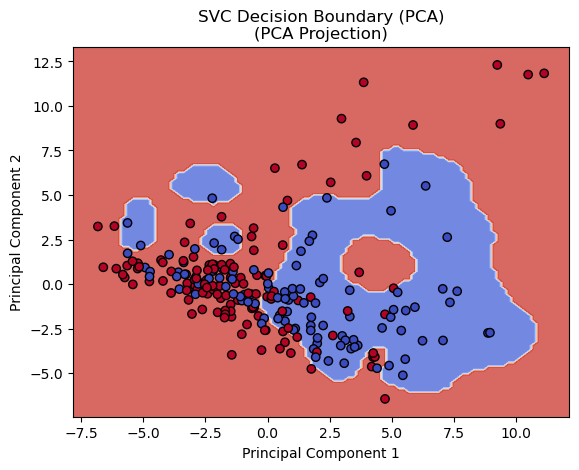

In [31]:
def plot_decision_boundary_pca(model, X, y, title="SVC Decision Boundary (PCA)"):
    """
    Project high-dimensional data to 2D using PCA for visualization
    """
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Train a new model on PCA-transformed data (for accurate boundary)
    model_pca = SVC(**params_dict)
    model_pca.fit(X_pca, y)
    
    # Plot decision boundary
    display = DecisionBoundaryDisplay.from_estimator(
        model_pca,
        X_pca,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
    )
    
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title(f"{title}\n(PCA Projection)")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

# Usage for high-dimensional data
plot_decision_boundary_pca(best_model, X_best, y)

# Run model and get outcomes


Final Model Evaluation on Test Set:
Accuracy: 0.7000
Precision: 0.7027
Recall: 0.7879
F1 Score: 0.7429
ROC AUC: 0.7632


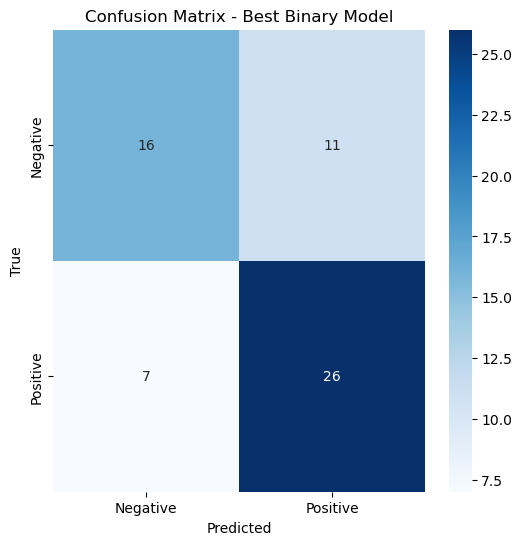

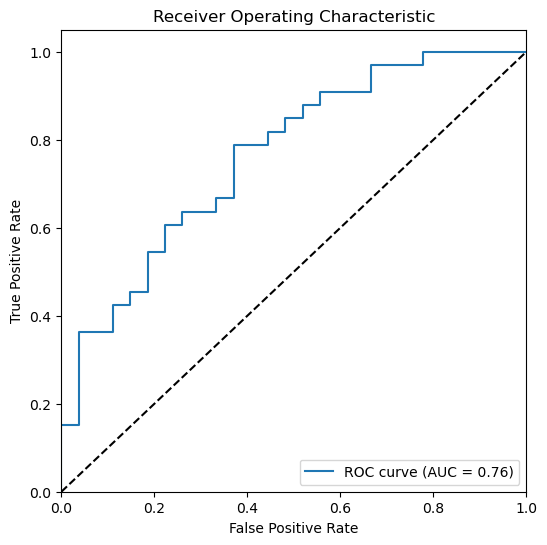

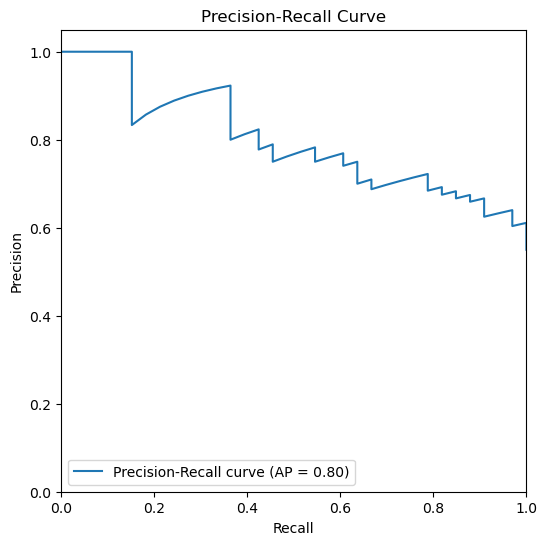

In [32]:
# Make predictions
y_pred = best_model.predict(X_test_final)
y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]  # Probabilities for class 1

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nFinal Model Evaluation on Test Set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Best Binary Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
plt.figure(figsize=(6,6))
plt.plot(recall_curve, precision_curve, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Get Best Features
https://www.geeksforgeeks.org/machine-learning/determining-feature-importance-in-svm-classifiers-with-scikit-learn/


FEATURE IMPORTANCE ANALYSIS
Number of features in final model: 65

Calculating permutation importance for rbf kernel...
65
Permutation Feature Importances:
                      feature  importance_mean  importance_std
                P4_abs_fft_20         0.017396        0.008589
               P4_norm_fft_20         0.015331        0.009142
                Oz_abs_fft_10         0.014905        0.010444
               O2_norm_fft_20         0.014186        0.006340
                O2_abs_fft_20         0.012660        0.007363
                       C4_SNR         0.012076        0.012637
                F4_abs_fft_20         0.011268        0.007776
                Oz_abs_fft_30         0.010887        0.007106
               PO7_abs_fft_10         0.010550        0.005687
                Fz_abs_fft_10         0.008956        0.010288
               Oz_norm_fft_30         0.008844        0.006703
               Oz_norm_fft_10         0.007767        0.009051
                O1_abs_f

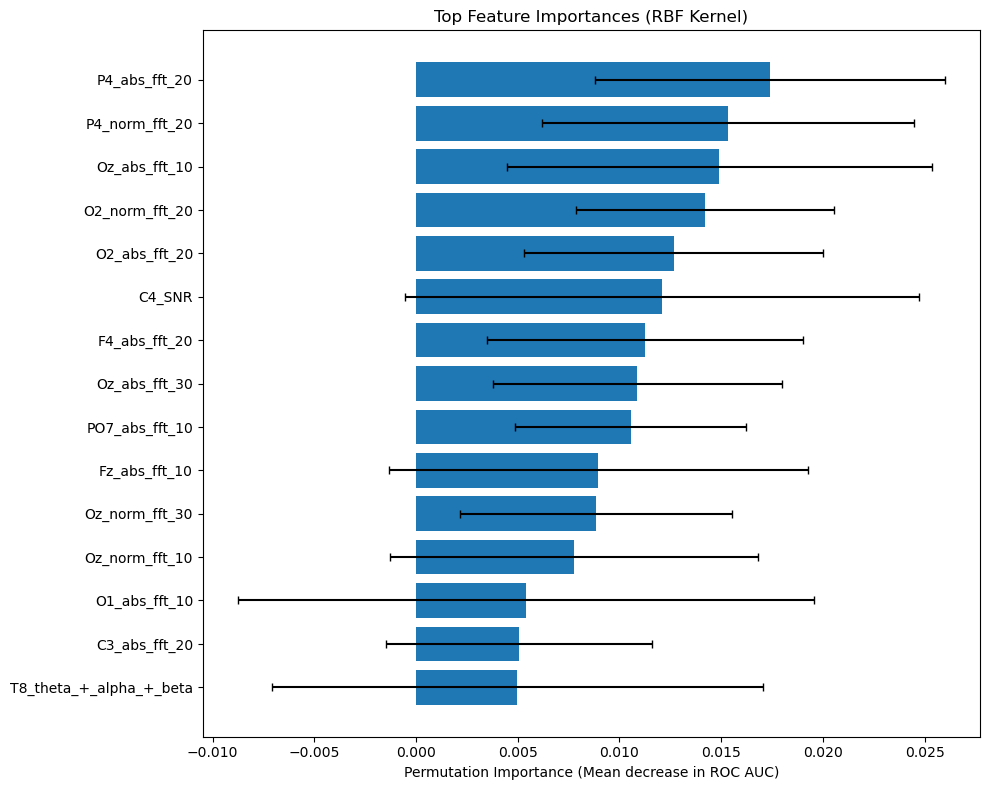


Permutation feature importance saved to 'permutation_feature_importance.csv'


In [33]:
from sklearn.inspection import permutation_importance

# FEATURE IMPORTANCE ANALYSIS
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get the final feature names after all processing
if best_fs_method != 'None':
    # selected_features already contains indices
    final_feature_names = binary_data.columns[selected_features].tolist()
else:
    # If no feature selection was used, get all original feature names
    final_feature_names = binary_data.columns.tolist()

print(f"Number of features in final model: {len(final_feature_names)}")

# Get feature importances based on kernel type
if best_model.kernel == 'linear':
    # For linear kernel, use coefficients directly
    coef = best_model.coef_
    
    if len(coef) == 1:  # Binary classification
        print("\nLinear SVC Feature Coefficients:")
        coefficients = coef[0]
        
        # Create DataFrame for better visualization
        feature_importance_df = pd.DataFrame({
            'feature': final_feature_names,
            'coefficient': coefficients,
            'abs_importance': np.abs(coefficients)
        })
        
        # Sort by absolute value for importance ranking
        feature_importance_df = feature_importance_df.sort_values('abs_importance', ascending=False)
        
        print(feature_importance_df.to_string(index=False))
        
        # Plot top features
        top_n = min(15, len(feature_importance_df))
        plt.figure(figsize=(10, 8))
        colors = ['red' if x < 0 else 'blue' for x in feature_importance_df['coefficient'].head(top_n)]
        plt.barh(range(top_n), feature_importance_df['coefficient'].head(top_n), color=colors)
        plt.yticks(range(top_n), feature_importance_df['feature'].head(top_n))
        plt.xlabel('Coefficient Value')
        plt.title('Top Feature Coefficients (Linear SVC)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        # plt.savefig('feature_importance_linear.png', dpi=300, bbox_inches='tight')
        plt.show()
        
else:
    # For non-linear kernels, use permutation importance
    print(f"\nCalculating permutation importance for {best_model.kernel} kernel...")
    
    results = permutation_importance(
        best_model, 
        X_test_final, 
        y_test, 
        n_repeats=50, 
        random_state=42,
        scoring='roc_auc'
    )
    print(len(results.importances_mean))
    
    # Create DataFrame with results
    importance_df = pd.DataFrame({
        'feature': final_feature_names,
        'importance_mean': results.importances_mean,
        'importance_std': results.importances_std
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('importance_mean', ascending=False)
    
    print("Permutation Feature Importances:")
    print(importance_df.to_string(index=False))
    
    # Plot top features
    top_n = min(15, len(importance_df))
    plt.figure(figsize=(10, 8))
    plt.barh(range(top_n), importance_df['importance_mean'].head(top_n), 
             xerr=importance_df['importance_std'].head(top_n), capsize=3)
    plt.yticks(range(top_n), importance_df['feature'].head(top_n))
    plt.xlabel('Permutation Importance (Mean decrease in ROC AUC)')
    plt.title(f'Top Feature Importances ({best_model.kernel.upper()} Kernel)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    # plt.savefig('feature_importance_permutation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Save feature importance results to CSV
if best_model.kernel == 'linear':
    feature_importance_df.to_csv('linear_feature_importance.csv', index=False)
    print("\nLinear feature importance saved to 'linear_feature_importance.csv'")
else:
    importance_df.to_csv('permutation_feature_importance.csv', index=False)
    print("\nPermutation feature importance saved to 'permutation_feature_importance.csv'")